In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras as keras

import cv2
import numpy as np

In [2]:
video_ids = [2] # range(1, 6)
frame_skip = 25

In [3]:
# Load the JSON metadata for each video and store the paths, hits, and serves
import json

frame_labels = {}
for id in video_ids:
    with open(f'data/json/video{id}.json') as f:
        video_data = json.load(f)

        video_start = video_data['match']['start']
        video_end = video_data['match']['end']
        
        # Create a dictionary to store the labels for each frame
        video_labels = {
            frame: {
                'shot': None,
                'player': None,
                'side': None,
                'type': None,
            }
            for frame in range(video_start, video_end, frame_skip)
        }

        # Add the labels for each hit
        for hit in video_data['hits']:
            hit_start = int(hit['start'])
            hit_end = int(hit['end'])
            hit_label = hit['custom']

            for frame in range(hit_start, hit_end):
                if frame in video_labels.keys():
                    video_labels[frame] = {
                        'shot': 'Hit',
                        'player': hit_label['Player'], #near or far
                        'side': hit_label['Side'],
                        'type': hit_label['Type'],
                    }

        # Add the labels for each serve
        for serve in video_data['serves']:
            serve_start = int(serve['start'])
            serve_end = int(serve['end'])
            serve_label = serve['custom']

            for frame in range(serve_start, serve_end):
                if frame in video_labels.keys():
                    video_labels[frame] = {
                        'shot': 'Serve',
                        'player': serve_label['Player'], #near or far
                        'side': serve_label['Result'],
                        'type': None,
                    }

        frame_labels[id] = video_labels

In [4]:
# Flatten the labels dictionary into a list of tuples
labels = np.array([
    [id, frame, label['shot'], label['player'], label['side'], label['type']]
    for id, video_labels in frame_labels.items()
    for frame, label in video_labels.items()
])

# Convert the shot, player, side, and type fields to ints
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for i in range(2, 6):
    label_encoders[i] = LabelEncoder()
    labels[:, i] = label_encoders[i].fit_transform(labels[:, i])

print(labels.shape)

(4828, 6)


In [5]:
# Load model
model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
movenet = model.signatures['serving_default']

2023-12-13 19:11:51.431439: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2023-12-13 19:11:51.431464: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2023-12-13 19:11:51.431467: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2023-12-13 19:11:51.431496: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-13 19:11:51.431512: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
data = np.empty((0, 17*3))
for id in video_ids:
    video = cv2.VideoCapture(f"data/videos/video{id}.mp4")
    for frame_num in range(video_start, video_end, frame_skip):
        print(f'Loading video {id}... ({frame_num-video_start}/{video_end-video_start})', end='\r')
        video.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        ret, frame = video.read()

        input_img = tf.expand_dims(frame, axis=0)
        input_img = tf.image.resize_with_pad(input_img, 192, 192)
        input_img = tf.cast(input_img, dtype=tf.int32)
        
        # Detection section
        keypoints_with_scores = movenet(input_img)['output_0'].numpy().flatten()
        data = np.vstack((data, keypoints_with_scores))

    video.release()

print(data.shape)

2023-12-13 19:11:56.052481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


(4828, 51)deo 2... (120675/120697)


In [7]:
# Define the model
model = keras.models.Sequential()
model.add(keras.layers.LSTM(128, input_shape=(51, 1)))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 75076 (293.27 KB)
Trainable params: 75076 (293.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
X = data
y = labels[:, 2:].astype(int)

In [37]:
# K-fold cross validation
from sklearn.model_selection import KFold
from keras.utils import to_categorical

kf = KFold(n_splits=5, shuffle=True)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print("Unique values in X_train: ", np.unique(X_train))
    print("Unique values in X_test: ", np.unique(X_test))
    print("Unique values in y_train: ", np.unique(y_train))
    print("Unique values in y_test: ", np.unique(y_test))
    y_train_one_hot = to_categorical(y_train,num_classes=4)
    y_test_one_hot = to_categorical(y_test,num_classes=4)

    print("X_train shape: ", X_train.shape)
    print("X_test shape: ", X_test.shape)
    print("Y_train shape: ", y_train.shape)
    print("Y_train shape: ", y_test.shape)
    print("Data type of y_train: ", y_train.dtype)
    print("Data type of y_test: ", y_test.dtype)
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy', # 'categorical_crossentropy
        metrics=["accuracy", "precision", "recall", "f1"]
    )

    earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)

    # Train the model
    model.fit(
        X_train,
        y_train_one_hot ,
        batch_size=32,
        epochs=100,
        validation_data=(X_test, y_test_one_hot),
        callbacks=[earlystopping],
    )

    # Evaluate the model
    model.evaluate(X_test, y_test, verbose=2)

Unique values in X_train:  [-0.01657235 -0.00821398 -0.00576937 ...  1.02204621  1.02361131
  1.03121245]
Unique values in X_test:  [0.00238215 0.00400717 0.00441993 ... 0.99473786 0.99866104 1.01257038]
Unique values in y_train:  [0 1 2 3 4 5 6]
Unique values in y_test:  [0 1 2 3 4 5 6]


IndexError: index 5 is out of bounds for axis 1 with size 4

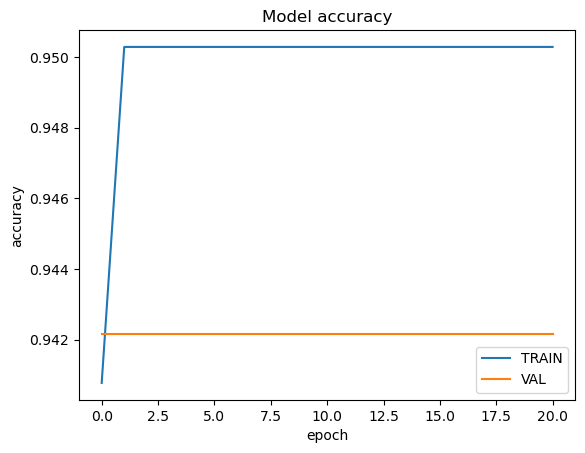

In [ ]:
import matplotlib.pyplot as plt

# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [ ]:
# Decode the predictions
def decode(prediction):
    decoded = []
    for i in range(2, 6):
        decoded.append(label_encoders[i].inverse_transform([np.argmax(prediction[i-2])])[0])
    return decoded

1/1 [==============================] - 1s 521ms/step
(4,)
['Hit', 'Far', 'Fault', 'Flat']


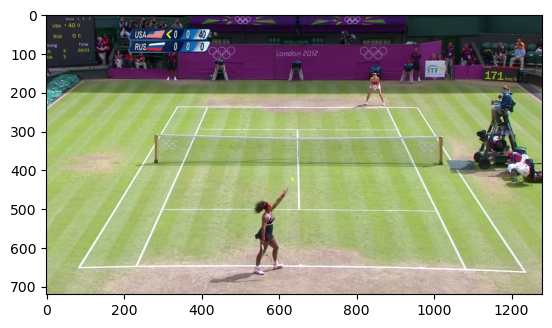

In [ ]:
# get frame 3000 from video 2
video = cv2.VideoCapture("data/videos/video1.mp4")
video.set(cv2.CAP_PROP_POS_FRAMES, 28000)
ret, frame = video.read()
video.release()

# show frame
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame)

# get keypoints
input_img = tf.expand_dims(frame, axis=0)
input_img = tf.image.resize_with_pad(input_img, 192, 192)
input_img = tf.cast(input_img, dtype=tf.int32)
keypoints_with_scores = movenet(input_img)['output_0'].numpy().flatten()

# predict
prediction = model.predict(np.expand_dims(keypoints_with_scores, axis=0)).flatten()
print(prediction.shape)
decoded = decode(prediction)
print(decoded)